#### This creates one csv file for all the 2D stacks with the contour properties PER rock sample (inclusive of all the three directions)

### Import all libraries

In [1]:
from __future__ import print_function
import os
import collections
import numpy as np
import six
import sys
import logging as logger
import time
import json
import os
import logging.config
import pandas as pd
import gc
import math
import cv2
import matplotlib.pyplot as plt
import porespy as ps
import cv2
import SimpleITK as sitk
import scipy.io as sio
import openpyxl

In [11]:
def contour_properties(contours, num_contours, slices, rock_type, d_img):
    
    "Function used to create a DataFrame that stores all the properties of a Contour"
    cont_dic = {}
    cont_df = pd.DataFrame()
    for num_cnt in range(0, num_contours):
        
        cnt = contours[num_cnt]
        #print(num_cnt, cnt)
        cont_dic['Contour Number'] = num_cnt
        cont_dic['Slice Number'] = slices
        cont_dic['Rock Type'] = rock_type
        cont_dic['Direction'] = d_img
                
        # Area and Perimeter
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        cont_dic['Contour Area'] = area
        cont_dic['Contour Perimeter'] = perimeter
        
        #Straight bounding rectangle: Aspect Ratio and Extent
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio_rect = float(w)/h
        cont_dic['Aspect Ratio Rectangle'] = aspect_ratio_rect
        rect_area = w*h
        extent = float(area)/rect_area
        cont_dic['Extent Rectangle'] = extent
        print('ASR:', aspect_ratio_rect)
        
        #Rotated Bounding Rectangle
        rect = cv2.minAreaRect(cnt)
        angle_rbr = rect[2]
        cont_dic['Rotated Rectangle Angle'] = angle_rbr
        
        if len(cnt) >= 5:
            (x,y),(MA,ma),angle = cv2.fitEllipse(cnt)
            aspect_ratio_ellipse = float(MA)/ma
            print('MA:',MA, 'ma:', ma)
            angle_ellipse = angle
            cont_dic['Aspect Ratio Ellipse'] = aspect_ratio_ellipse
            cont_dic['Angle Ellipse'] = angle_ellipse
            print('ASE:',aspect_ratio_ellipse)
        else:
            cont_dic['Aspect Ratio Ellipse'] = -100
            cont_dic['Angle Ellipse'] = -100
            
        cont_dic['Contour Points'] = cnt   
        
        # Image moments
        M = cv2.moments(cnt)
        
        # Hu Moments
        H = cv2.HuMoments(M)
        H_dict = {'Hu1':H[0][0], 'Hu2':H[1][0], 'Hu3':H[2][0], 'Hu4':H[3][0], 'Hu5':H[4][0], 'Hu6':H[5][0], 'Hu7':H[6][0]}
        
        # Adding elements from dict2 to dict1
        cont_dic.update(M)
        cont_dic.update(H_dict)
        cont_df = cont_df.append(cont_dic, ignore_index=True)
        
    return cont_df        

Starting the automation loop for fracture identification - Bentheimer
The data type for b_matfile is: <class 'dict'>
The data type for ben is: <class 'numpy.ndarray'>
The size of bentheimer sandstone image is: (300, 300, 300)
The unique values in ben is: [0 1]
1 represents Pores and 0 represents Grains
Image Number and Direction: 1 z
Extracting first slice for display: ben [0:300][0:300][0]
ASR: 5.0
MA: 1.9718724489212036 ma: 19.000612258911133
ASE: 0.10377941626572647
ASR: 1.0
MA: 1.5351358652114868 ma: 7.003715991973877
ASE: 0.21918876593093192
ASR: 0.8
MA: 3.094454765319824 ma: 4.546144008636475
ASE: 0.6806768020197285
ASR: 2.5
MA: 0.0 ma: 1.0
ASE: 0.0
ASR: 0.75
MA: 2.199129104614258 ma: 3.7746479511260986
ASE: 0.5826050887628307
ASR: 0.25
MA: 0.0 ma: 2.746899127960205
ASE: 0.0
ASR: 0.65
MA: 6.680493354797363 ma: 20.632125854492188
ASE: 0.3237908396794136
ASR: 0.9166666666666666
MA: 4.861665725708008 ma: 14.692299842834473
ASE: 0.33089889110036597
ASR: 1.0
ASR: 1.3333333333333333
MA

ASR: 1.0
ASR: 1.8333333333333333
MA: 4.017336368560791 ma: 10.168960571289062
ASE: 0.3950587024502088
ASR: 1.25
MA: 10.730489730834961 ma: 13.765719413757324
ASE: 0.7795080960397185
ASR: 0.4
MA: 0.0 ma: 1.0
ASE: 0.0
ASR: 0.75
MA: 7.19465446472168 ma: 11.019315719604492
ASE: 0.6529129982111005
ASR: 1.0
MA: 2.218811273574829 ma: 2.66616153717041
ASE: 0.8322118681262078
ASR: 1.125
MA: 4.933084964752197 ma: 9.878473281860352
ASE: 0.49937726448182285
ASR: 1.2307692307692308
MA: 10.119797706604004 ma: 15.947953224182129
ASE: 0.6345515041553544
ASR: 0.5
ASR: 1.0
MA: 3.932936191558838 ma: 6.361048698425293
ASE: 0.618284244944148
ASR: 1.0
MA: 2.91131329536438 ma: 3.287623643875122
ASE: 0.8855372788148022
ASR: 1.0833333333333333
MA: 24.279468536376953 ma: 40.136077880859375
ASE: 0.6049287777557275
ASR: 0.3225806451612903
MA: 8.60299301147461 ma: 29.52655601501465
ASE: 0.2913645942012293
ASR: 1.0
ASR: 0.6551724137931034
MA: 30.098276138305664 ma: 58.597206115722656
ASE: 0.5136469489494956
ASR: 0.

PermissionError: [Errno 13] Permission denied: 'D:\\Fracture Identification\\version_3\\Properties_Excel\\Ben_1_z.csv'

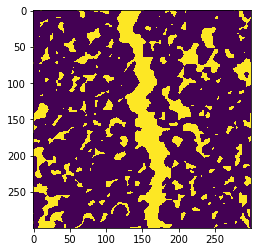

In [12]:
%%time
print("Starting the automation loop for fracture identification - Bentheimer")

num_im = [1]
direction_im = ['z']

for num_img in num_im:
    
    for d_img in direction_im:
        cont_df_full = pd.DataFrame()
        matfile_name = 'D:\\Fracture Identification\\version_3\\Priliminary Samples\\Python_Mat_files\\ben{}_{}.mat'.format(num_img, d_img)
        b_matfile = sio.loadmat(matfile_name)
        print('The data type for b_matfile is:', type(b_matfile))
        ben = b_matfile['FinalImage']
        print('The data type for ben is:', type(ben))
        print('The size of bentheimer sandstone image is:', ben.shape)
        print('The unique values in ben is:', np.unique(ben))
        print('1 represents Pores and 0 represents Grains')
        print('Image Number and Direction:', num_img, d_img)

        print("Extracting first slice for display: ben [0:300][0:300][0]")
        ben_slice = ben[0:ben.shape[0], 0:ben.shape[1], 0]
        plt.imshow(ben_slice)
        
        rock_type = 'Ben_{}'.format(num_img)

        for slices in range(0, 2):

            ben_slice = ben[0:ben.shape[0], 0:ben.shape[1], slices] #extract a 2D slice for investigation
            contours, hierarchy = cv2.findContours(ben_slice, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
            num_contours = len(contours)
            #print('The number of contours identified in the image:', num_contours) 
            cont_df_slice = contour_properties(contours, num_contours, slices+1, rock_type, d_img)

            cont_df_full = cont_df_full.append(cont_df_slice, ignore_index = True)
        print('Contours extracted for:', rock_type, 'and direction:', d_img)
    
        cont_df_full = cont_df_full[['Rock Type','Direction','Slice Number','Contour Number', 'Contour Perimeter', 'Contour Area', 'Angle Ellipse', 'Aspect Ratio Ellipse',
                              'Aspect Ratio Rectangle', 'Extent Rectangle','Rotated Rectangle Angle', 'm00', 'm01', 'm02', 
                              'm03', 'm10', 'm11', 'm12', 'm20', 'm21', 'm30', 'mu02', 'mu03', 'mu11', 'mu12', 'mu20', 
                              'mu21','mu30', 'nu02', 'nu03', 'nu11', 'nu12', 'nu20', 'nu21', 'nu30', 'Contour Points']]

        df_filename = "D:\\Fracture Identification\\version_3\\Properties_Excel\\{}_{}.csv".format(rock_type, d_img)        
        cont_df_full.to_csv(df_filename, index = False, header=True)